In [1]:
from pathlib import Path
import requests
from tqdm.auto import tqdm
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import PIL
import time
import os
import copy
import gc

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch import nn
import torch.optim as optim

In [3]:
from efficientnet_pytorch import EfficientNet

# Download and Untar Data

In [4]:
def dl(url, dest_dir):
    assert isinstance(dest_dir, Path), "dest_dir must be a Path object"
    filename = url.split('/')[-1]
    file_path = dest_dir / filename
    if not file_path.exists():
        with open(f'{dest_dir}/{filename}', 'wb') as f:
            response = requests.get(url, stream=True)
            total = int(response.headers.get('content-length'))
            with tqdm(total=total, unit='B', unit_scale=True, desc=filename) as pbar:
                for data in response.iter_content(chunk_size=1024*1024):
                    f.write(data)
                    pbar.update(1024*1024)
    else:
        return file_path
    return file_path

def untar_tgz(tgz_path, dest_dir):
    assert isinstance(tgz_path, Path), "tgz_path must be a Path object"
    assert tgz_path.exists(), "tgz_path does not exists"
    assert tgz_path.suffix == ".tgz", "tgz_path is not a .tgz file"
    if tgz_path.stem == "car_devkit":
        final_path = dest_dir / "devkit"
    else:
        final_path = dest_dir / tgz_path.stem
    if not final_path.exists():
        tar = tarfile.open(tgz_path, 'r:gz')
        tar.extractall(dest_dir)
    return final_path

In [5]:
WD_PATH = Path(".")
DATA_PATH = WD_PATH / "Data"

In [6]:
if not DATA_PATH.exists():
    DATA_PATH.mkdir()

In [7]:
train_url = "http://imagenet.stanford.edu/internal/car196/cars_train.tgz"
test_url = "http://imagenet.stanford.edu/internal/car196/cars_test.tgz"
devkit_url = "https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz"
test_annos_withlabels_url = "http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat"

In [8]:
train_tar_path = dl(train_url, DATA_PATH)
test_tar_path = dl(test_url, DATA_PATH)
devkit_tar_path = dl(devkit_url, DATA_PATH)

In [9]:
train_path = untar_tgz(train_tar_path, DATA_PATH)
test_path = untar_tgz(test_tar_path, DATA_PATH)
devkit_path = untar_tgz(devkit_tar_path, DATA_PATH)
dl(test_annos_withlabels_url, devkit_path)

WindowsPath('Data/devkit/cars_test_annos_withlabels.mat')

# Explore using Fastai Library

In [10]:
def get_idx2name_map():
    cars_metas = scipy.io.loadmat(devkit_path / 'cars_meta.mat')
    cars_metas = cars_metas['class_names'].squeeze()
    df = pd.DataFrame(cars_metas, columns=['class_names'])
    df = df.applymap(np.squeeze)
    df.insert(loc=0, column='class_idx', value=np.arange(1, len(df)+1))
    idx2name_map = {df.iloc[i, 0]:df.iloc[i, 1] for i in range(len(df))}
    return idx2name_map

def get_cars_df(annos_matfile):
    assert annos_matfile in ['cars_train_annos.mat', 'cars_test_annos_withlabels.mat'], \
           "Please select 'cars_train_annos.mat' or 'cars_test_annos_withlabels.mat'"
           
    cars_annos = scipy.io.loadmat(devkit_path / annos_matfile)
    cars_annos = cars_annos['annotations'].squeeze()
    df = pd.DataFrame(cars_annos)
    df = df.applymap(np.squeeze)
    idx2name_map = get_idx2name_map()
    df['class_name'] = df['class'].map(idx2name_map)
    
    return df[['fname', 'class_name', 'class']]

In [11]:
train_df = get_cars_df('cars_train_annos.mat')
test_df = get_cars_df('cars_test_annos_withlabels.mat')

In [12]:
train_df.head()

,fname,class_name,class
0,00001.jpg,Audi TTS Coupe 2012,14
1,00002.jpg,Acura TL Sedan 2012,3
2,00003.jpg,Dodge Dakota Club Cab 2007,91
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,134
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,106


In [13]:
import fastai
from fastai.vision import *

In [14]:
tfms = get_transforms(
    do_flip = True,
    flip_vert = False,
    max_rotate = 20.0,
    max_zoom = 0.5,
    max_lighting = 0.2,
    max_warp = 0.2,
    p_affine = 0.75,
    p_lighting = 0.75,
#     xtra_tfms = rand_resize_crop(size=224, max_scale=0.8)
)

In [15]:
img_data = ImageDataBunch.from_df(train_path, train_df,
                                  ds_tfms=tfms, size=224, fn_col=0, label_col=1, valid_pct=0.2, bs=34)

In [16]:
img_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data\cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FIAT 500 Abarth 2012,Bentley Continental Flying Spur Sedan 2007,Suzuki Kizashi Sedan 2012,Jeep Grand Cherokee SUV 2012,Chevrolet Sonic Sedan 2012
Path: Data\cars_train;

Test: None

In [17]:
# img_data.show_batch(rows=3, figsize=(12,10))

# Efficientnet-b0

In [18]:
eff_net = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [19]:
num_classes = 196
eff_net._fc = nn.Linear(1280, num_classes)
torch.nn.init.kaiming_normal_(eff_net._fc.weight)

Parameter containing:
tensor([[ 0.0379, -0.0602, -0.0054,  ...,  0.0214, -0.0219, -0.0102],
        [-0.0344,  0.0566,  0.0209,  ...,  0.0192, -0.0037, -0.0241],
        [-0.0326, -0.0644, -0.0342,  ..., -0.0259,  0.0276,  0.0629],
        ...,
        [ 0.0143, -0.0297,  0.0162,  ..., -0.0404, -0.0029,  0.0209],
        [-0.0394, -0.0456,  0.0075,  ..., -0.0392,  0.0218, -0.0110],
        [ 0.0210,  0.0455, -0.0451,  ...,  0.0263,  0.0514,  0.0015]],
       requires_grad=True)

In [20]:
learn = Learner(img_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.')
l_groups = [[eff_net._conv_stem, eff_net._bn0] + list(eff_net._blocks[0:8]),
            list(eff_net._blocks[8:]) + [eff_net._conv_head, eff_net._bn1],
            [eff_net._fc]
           ]
learn.split(l_groups)
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


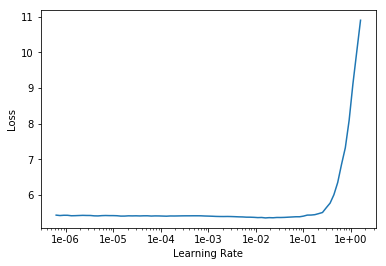

In [21]:
learn.lr_find()
learn.recorder.plot(skip_end=5)

In [22]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.781491,4.287774,0.136364,01:38
1,3.657434,3.546006,0.230958,01:35
2,3.034654,3.268669,0.283170,01:35
3,2.540702,3.377674,0.278870,01:36
4,2.119019,3.352768,0.292383,01:34
5,1.746942,3.316457,0.308354,01:34
6,1.457736,3.100626,0.342138,01:35
7,1.198649,3.056527,0.344595,01:33
8,1.028819,2.998848,0.339681,01:39


KeyboardInterrupt: 

In [ ]:
learn.unfreeze()

In [ ]:
lr = 3e-3
learn.fit_one_cycle(20, [lr/100, lr/10, lr])

In [ ]:
learn.recorder.plot_losses()